## Python porting of ZLSMA - Zero Lag LSMA by veryfid

<https://ru.tradingview.com/script/3LGnSrQN-ZLSMA-Zero-Lag-LSMA/>

>Developed by [@edyatl](https://github.com/edyatl) January 2023 <edyatl@yandex.ru>

In [1]:
# Load Jupyter extension for auto correction coding style based on Black Lib
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
import talib as tl

# from sklearn.linear_model import LinearRegression

# Nicest style for plots
sns.set(style="ticks")

<IPython.core.display.Javascript object>

### Original Indicator code

```python
study(title = "ZLSMA - Zero Lag LSMA", shorttitle="ZLSMA", overlay=true, resolution="")
length = input(title="Length", type=input.integer, defval=32)
offset = input(title="Offset", type=input.integer, defval=0)
src = input(close, title="Source")
lsma = linreg(src, length, offset)
lsma2 = linreg(lsma, length, offset)
eq= lsma-lsma2
zlsma = lsma+eq

plot(zlsma, color=color.yellow, linewidth=3)
```

**formula:** `linreg = intercept + slope * (length - 1 - offset)`

`linreg(source, length, offset) → series[float]`

where 
* **length** is the y argument, 
* **offset** is the z argument, 
* **intercept** and **slope** are the values calculated with the least squares method on source series (x argument)

Download [Dataset](https://data.binance.vision/?prefix=data/spot/daily/klines/BTCUSDT/) from Binance and unzip

In [3]:
dataset_path = "../"
col_names = [
    "Open time",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Close time",
    "Quote asset volume",
    "Number of trades",
    "Taker buy base asset volume",
    "Taker buy quote asset volume",
    "Ignore",
]

short_col_names = [
    "open_time",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "close_time",
    "qav",
    "num_trades",
    "taker_base_vol",
    "taker_quote_vol",
    "ignore",
]

<IPython.core.display.Javascript object>

In [4]:
# Load Dataset
df1 = pd.read_csv(
    dataset_path + "BTCUSDT-15m-2023-01-19.csv",
    names=col_names,
)
df2 = pd.read_csv(
    dataset_path + "BTCUSDT-15m-2023-01-20.csv",
    names=col_names,
)
data = pd.concat([df1, df2], ignore_index=True)

<IPython.core.display.Javascript object>

In [5]:
data["Open time"] = pd.to_datetime(data["Open time"], unit="ms")
data["Close time"] = pd.to_datetime(data["Close time"], unit="ms")
data

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2023-01-19 00:00:00,20677.47,20741.35,20660.15,20729.35,3420.32260,2023-01-19 00:14:59.999,7.083480e+07,80834,1756.96631,3.638896e+07,0
1,2023-01-19 00:15:00,20728.52,20764.64,20673.84,20709.14,2525.09524,2023-01-19 00:29:59.999,5.232198e+07,66226,1261.56974,2.614169e+07,0
2,2023-01-19 00:30:00,20709.14,20742.67,20686.42,20720.82,2394.79397,2023-01-19 00:44:59.999,4.962184e+07,66651,1259.91730,2.610639e+07,0
3,2023-01-19 00:45:00,20721.69,20741.19,20684.05,20694.01,2150.11042,2023-01-19 00:59:59.999,4.452688e+07,59372,1060.16417,2.195617e+07,0
4,2023-01-19 01:00:00,20694.64,20731.43,20676.32,20726.39,1959.56324,2023-01-19 01:14:59.999,4.058144e+07,58444,1039.81729,2.153480e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...
187,2023-01-20 22:45:00,22629.08,22690.76,22556.00,22595.08,3791.66301,2023-01-20 22:59:59.999,8.572384e+07,90185,1681.39467,3.801848e+07,0
188,2023-01-20 23:00:00,22593.98,22650.62,22537.80,22648.96,3891.32550,2023-01-20 23:14:59.999,8.801160e+07,75206,1893.54990,4.283335e+07,0
189,2023-01-20 23:15:00,22648.96,22755.93,22608.21,22650.41,5524.89511,2023-01-20 23:29:59.999,1.252638e+08,109538,2769.01849,6.278607e+07,0
190,2023-01-20 23:30:00,22650.44,22678.36,22590.00,22675.44,3523.71216,2023-01-20 23:44:59.999,7.975246e+07,82408,1680.24467,3.803244e+07,0


<IPython.core.display.Javascript object>

In [6]:
length: int = 32  # 32
offset: int = 10
src: pd.Series = data["Close"]
# data[["Open time", "Close time"]].tail(10)

<IPython.core.display.Javascript object>

### Using linreg from repo [Pandas TA - A Technical Analysis Library in Python 3](https://github.com/twopirllc/pandas-ta)

In [7]:
# The result of the function below occur in fact different from TradingView :(
def linreg_ta(src, length=None, offset=None, **kwargs):
    """Indicator: Linear Regression"""
    # Validate arguments
    length = int(length) if length and length > 0 else 14
    src = None if src.size < length or not isinstance(src, pd.Series) else src
    offset = int(offset) if isinstance(offset, int) else 0
    angle = kwargs.pop("angle", False)
    intercept = kwargs.pop("intercept", False)
    degrees = kwargs.pop("degrees", False)
    r = kwargs.pop("r", False)
    slope = kwargs.pop("slope", False)
    tsf = kwargs.pop("tsf", False)

    if src is None: return

    # Calculate Result
    x = range(1, length + 1)  # [1, 2, ..., n] from 1 to n keeps Sum(xy) low
    x_sum = 0.5 * length * (length + 1)
    x2_sum = x_sum * (2 * length + 1) / 3
    divisor = length * x2_sum - x_sum * x_sum

    def linear_regression(series):
        y_sum = series.sum()
        xy_sum = (x * series).sum()

        m = (length * xy_sum - x_sum * y_sum) / divisor
        if slope:
            return m
        b = (y_sum * x2_sum - x_sum * xy_sum) / divisor
        if intercept:
            return b

        if angle:
            theta = np.arctan(m)
            if degrees:
                theta *= 180 / np.pi
            return theta

        if r:
            y2_sum = (series * series).sum()
            rn = length * xy_sum - x_sum * y_sum
            rd = (divisor * (length * y2_sum - y_sum * y_sum)) ** 0.5
            return rn / rd

        return m * length + b if tsf else m * (length - 1) + b

    def rolling_window(array, length):
        """https://github.com/twopirllc/pandas-ta/issues/285"""
        strides = array.strides + (array.strides[-1],)
        shape = array.shape[:-1] + (array.shape[-1] - length + 1, length)
        return as_strided(array, shape=shape, strides=strides)

    if np.version.version >= "1.20.0":
        from numpy.lib.stride_tricks import sliding_window_view
        linreg_ = [linear_regression(_) for _ in sliding_window_view(np.array(src), length)]
    else:
        from numpy.lib.stride_tricks import as_strided
        linreg_ = [linear_regression(_) for _ in rolling_window(np.array(src), length)]

    linreg = pd.Series([np.nan] * (length - 1) + linreg_, index=src.index)

    # Offset
    if offset != 0:
        linreg = linreg.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        linreg.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        linreg.fillna(method=kwargs["fill_method"], inplace=True)

    # Name and Categorize it
    linreg.name = f"LR"
    if slope: linreg.name += "m"
    if intercept: linreg.name += "b"
    if angle: linreg.name += "a"
    if r: linreg.name += "r"

    linreg.name += f"_{length}"
    linreg.category = "overlap"

    return linreg


<IPython.core.display.Javascript object>

### Using [Python wrapper](https://github.com/TA-Lib/ta-lib-python) for [TA-LIB](http://ta-lib.org/) based on Cython instead of SWIG.

In [8]:
def linreg(src: pd.Series, length: int = None, offset: int = None) -> pd.Series:
    """Indicator: Linear Regression with TA-LIB module"""
    # Validate arguments
    src = None if src.size < length or not isinstance(src, pd.Series) else src
    length = int(length) if isinstance(length, int) and length > 0 else 32
    offset = int(offset) if isinstance(offset, int) else 0

    # Offset
    if offset != 0:
        # linreg = intercept + slope * (length - 1 - offset)
        return tl.LINEARREG_INTERCEPT(src, length) + tl.LINEARREG_SLOPE(src, length) * (
            length - 1 - offset
        )

    return tl.LINEARREG(src, length)

<IPython.core.display.Javascript object>

In [9]:
lsma: pd.Series = linreg(src, length, offset)  # ta.linreg(src, length, offset)
lsma2: pd.Series = linreg(lsma, length, offset)
lsma.tail(10)

182    21656.896472
183    21709.794173
184    21766.160343
185    21829.729960
186    21894.186754
187    21953.543891
188    22013.393286
189    22070.348569
190    22125.782863
191    22177.616754
dtype: float64

<IPython.core.display.Javascript object>

In [10]:
eq = lsma - lsma2
zlsma = lsma + eq
data["zlsma"] = zlsma
data[["Open time", "Close time", "zlsma"]].tail(10)

,Open time,Close time,zlsma
182,2023-01-20 21:30:00,2023-01-20 21:44:59.999,22000.504618
183,2023-01-20 21:45:00,2023-01-20 21:59:59.999,22075.704480
184,2023-01-20 22:00:00,2023-01-20 22:14:59.999,22155.729763
185,2023-01-20 22:15:00,2023-01-20 22:29:59.999,22247.701926
186,2023-01-20 22:30:00,2023-01-20 22:44:59.999,22339.042077
187,2023-01-20 22:45:00,2023-01-20 22:59:59.999,22418.205302
188,2023-01-20 23:00:00,2023-01-20 23:14:59.999,22496.443445
189,2023-01-20 23:15:00,2023-01-20 23:29:59.999,22567.265257
190,2023-01-20 23:30:00,2023-01-20 23:44:59.999,22633.613690
191,2023-01-20 23:45:00,2023-01-20 23:59:59.999,22691.651051


<IPython.core.display.Javascript object>

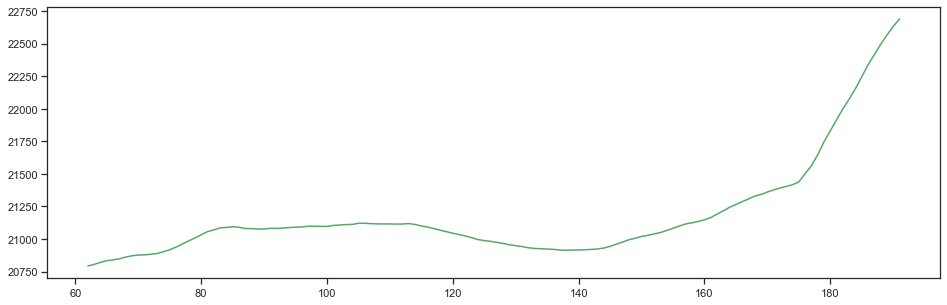

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(16, 5))
plt.plot(range(192), zlsma, color="g")
plt.show()

In [12]:
# Install a pip package in the current Jupyter kernel
# import sys

# !{sys.executable} -m pip install -U python-dotenv

<IPython.core.display.Javascript object>

In [13]:
import os
from os import environ as env
from dotenv import load_dotenv
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager

<IPython.core.display.Javascript object>

In [14]:
project_dotenv = os.path.join(os.path.abspath(""), ".env")
if os.path.exists(project_dotenv):
    load_dotenv(project_dotenv)

<IPython.core.display.Javascript object>

In [15]:
api_key, api_secret = env.get("ENV_API_KEY"), env.get("ENV_SECRET_KEY")
client = Client(api_key, api_secret)

<IPython.core.display.Javascript object>

In [16]:
klines = client.get_klines(symbol="BTCUSDT", interval=Client.KLINE_INTERVAL_15MINUTE)

<IPython.core.display.Javascript object>

In [20]:
kdf = pd.DataFrame(klines, columns=short_col_names)
kdf["open_time"] = pd.to_datetime(kdf["open_time"], unit="ms")
kdf["close_time"] = pd.to_datetime(kdf["close_time"], unit="ms")
kdf

,open_time,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,2023-01-18 10:45:00,21192.18000000,21210.00000000,21164.51000000,21183.83000000,1918.95079000,2023-01-18 10:59:59.999,40668251.60883070,57113,969.57549000,20549547.42089480,0
1,2023-01-18 11:00:00,21183.02000000,21214.07000000,21172.90000000,21212.08000000,1749.67672000,2023-01-18 11:14:59.999,37084883.39819170,55011,911.82670000,19327371.17621450,0
2,2023-01-18 11:15:00,21212.76000000,21222.74000000,21186.76000000,21210.39000000,1812.40149000,2023-01-18 11:29:59.999,38432052.01920990,51810,920.68260000,19523188.37965800,0
3,2023-01-18 11:30:00,21209.88000000,21237.47000000,21196.04000000,21220.21000000,1859.20325000,2023-01-18 11:44:59.999,39447192.41039640,50928,945.61717000,20064197.17749020,0
4,2023-01-18 11:45:00,21220.21000000,21224.29000000,21197.14000000,21204.67000000,1582.90133000,2023-01-18 11:59:59.999,33575593.42750440,45304,764.25734000,16211253.32034300,0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2023-01-23 14:30:00,22793.63000000,22821.29000000,22734.43000000,22803.53000000,5367.24961000,2023-01-23 14:44:59.999,122205912.42263360,121017,2757.33985000,62784699.42795800,0
496,2023-01-23 14:45:00,22801.73000000,23115.00000000,22500.00000000,22622.05000000,12844.34869000,2023-01-23 14:59:59.999,293503733.20322160,228426,6372.49396000,145696015.37924500,0
497,2023-01-23 15:00:00,22627.71000000,22799.00000000,22586.68000000,22775.00000000,11045.25383000,2023-01-23 15:14:59.999,250701975.58111110,193992,5633.32324000,127870798.40533600,0
498,2023-01-23 15:15:00,22774.37000000,22873.37000000,22737.49000000,22864.28000000,5691.22522000,2023-01-23 15:29:59.999,129813214.54945950,129992,2909.18484000,66360936.27142760,0


<IPython.core.display.Javascript object>